In [1]:
%matplotlib inline
from mpl_toolkits.basemap import Basemap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import spatial
from itertools import product
from matplotlib import ticker
from matplotlib.mlab import griddata
import matplotlib.colors as colors
from matplotlib import ticker
from matplotlib.mlab import griddata
from matplotlib.patches import Polygon
# from bs4 import BeautifulStoneSoup as Soup
import bs4 as bs
from matplotlib.colors import LinearSegmentedColormap
from utilities.plotting import equi

In [2]:
m_standard = Basemap(projection='robin', lon_0=0)

def draw_screen_poly( lats, lons, m, ax):
    x, y = m( lons, lats )
    xy = zip(x,y)
    poly = Polygon( xy, facecolor='None', alpha=1.0, linewidth=3, linestyle='--' )
    ax.add_patch(poly)

def parse_coords(c):
    c = c.replace('\t', '')
    c = c.replace('\n', '')
    c = c.strip()
    c = c.split(' ')
    c = [[float(co) for co in coord.split(',')] for coord in c]
    c = np.array([np.array(co) for co in c])
    return c

def create_grid(axis_1_min_max, axis_2_min_max, axis_3_min_max
                , axis_1_increment, axis_2_increment, axis_3_increment\
               , columns=['longitude', 'latitude', 'depth']):
    axis_1_min, axis_1_max = axis_1_min_max
    axis_2_min, axis_2_max = axis_2_min_max
    axis_3_min, axis_3_max = axis_3_min_max

    axis_1_numpoints = (axis_1_max - axis_1_min)/axis_1_increment + 1
    axis_2_numpoints = (axis_2_max - axis_2_min)/axis_2_increment + 1
    axis_3_numpoints = (axis_3_max - axis_3_min)/axis_3_increment + 1


    axis_1 = np.linspace(axis_1_min, axis_1_max, axis_1_numpoints).round(2)
    axis_2 = np.linspace(axis_2_min, axis_2_max, axis_2_numpoints).round(2)
    axis_3 = np.linspace(axis_3_min, axis_3_max, axis_3_numpoints).round(2)

    axis123 = list(product(axis_1, axis_2, axis_3))
    grid = pd.DataFrame(axis123, columns=columns)
    return grid

def get_node_data(node, radius, data, m=m_standard):
#     m = Basemap(projection='robin', lon_0=0)
    node_lon = node[0]
    node_lat = node[1]
    radius = radius
    distance_from_node = (radius + 10)/111.133
    data = data[data.lon.between(node_lon-distance_from_node, node_lon+distance_from_node)
              & data.lat.between(node_lat-distance_from_node, node_lon+distance_from_node)].copy()
    xy = np.array(m(data.lon.values, data.lat.values)).transpose()
    node_xy = np.array([m(node_lon, node_lat)])
#     dist = scipy.spatial.distance.cdist(xy, node_xy)/1000. #cdist is meters, we want km
    dist = spatial.distance.cdist(xy, node_xy)/1000. #cdist is meters, we want km
    data['distance'] = dist[:,0]
    data = data[data.distance <= radius]
    return data

def mc_maximum_curvature(magnitudes):
    """
    :param catalog : pandas Series
    :param method : string
    """
    minimum = round(magnitudes.min(), 2)
    bins = np.arange(start=minimum, stop=10, step=0.1)
    hist, edges = np.histogram(a=magnitudes, range=(minimum, 10), bins=bins)
    hist_maximum_index = np.argmax(hist)
    return round(edges[hist_maximum_index], 2)

def fmd_values(magnitudes, bin_width=0.1):
    """
    params magnitudes : numpy.array
    params bin_width : float

    returns a,b,bstd, n-values if above the earthquake count threshold
    else returns np.nans
    """
    length = magnitudes.shape[0]
    minimum = magnitudes.min()
    average = magnitudes.mean()
    b_value = (1 / (average - (minimum - (bin_width / 2)))) * np.log10(np.exp(1))

    square_every_value = np.vectorize(lambda x: x ** 2)
    b_stddev = square_every_value((magnitudes - average).sum()) / (length * (length - 1))
    b_stddev = 2.3 * np.sqrt(b_stddev) * b_value ** 2
    a_value = np.log10(length) + b_value * minimum

    return a_value, b_value, b_stddev, length

def calc_fmd_stats_with_mc(magnitudes):
    if len(magnitudes) > 0:
        mc = mc_maximum_curvature(magnitudes) + 0.2
        magnitudes = magnitudes[magnitudes >= mc]
        if len(magnitudes) > 0:
            fmd_stats = fmd_values(magnitudes)
            return fmd_stats + (mc,)
        else: return (np.nan, np.nan, np.nan, np.nan, np.nan)
    else:
        return (np.nan, np.nan, np.nan, np.nan, np.nan)
    
def node_pipeline(node, data, radius):
    node_data = get_node_data(node=node, data=data, radius=radius)
    statistics = calc_fmd_stats_with_mc(node_data.mag)
    return statistics

def grid_statistic_pipeline(grid, data, radius):
    stats = []
    for node in grid:
        stats.append(node_pipeline(node=node, data=data, radius=radius) + (node[0], node[1]))
    return np.array(stats)

# def save_fig(fig, ax, name):
#     fig.savefig(name, bbox_inches='tight')

def gr_plot(gr_data, *args, **kwargs):
    fig, ax = plt.subplots(1, figsize=(6, 5))
    hist, edges = np.histogram(a=gr_data, bins=100, range=(0,10))
    chist = np.cumsum(hist[::-1])
#     ax.scatter(edges[:-1], hist, marker='s', facecolor='None', label='discrete')
#     ax.scatter(edges[::-1][:-1], chist, marker='^', facecolor='red', s=25, label='cumulative')
    ax.scatter(edges[::-1][:-1], chist, marker='^', s=25, label='cumulative')
    ax.set_yscale('log')
    ax.set_ylabel('N', rotation=0, fontsize=12)
    ax.set_xlabel('Magnitude')
    ax.legend()
    ax.grid(True)
    ax.set_ylim(1e0, chist[-1])
    ax.set_xlim(0, 10)
    # ax.set_title('Frequency Magnitude Distribution')

    a, b, bstd, n, mc = calc_fmd_stats_with_mc(gr_data)

    x = np.arange(0,10, 0.1)
    y = 10**(a - b * x)

    ax.plot(x, y)
    ax.text(s = 'Mc = {mc}\nb = {b}\nn = {n}'.format(mc=mc, b=round(b,3), n=n), x=7, y=chist.max()/10., fontsize=12)
    return fig, ax

def mc_plot(data, lons, lats, lon_i, lat_i, min_mag):
    zi = data.pivot(index='lat', columns='lon', values='mc').values
    fig, ax = plt.subplots()
    m = Basemap(projection='merc'
        , llcrnrlat=27.5        # the LOWER LEFT corner of latitude
        , urcrnrlat=35.5        # the UPPER RIGHT corner of latitude
        , llcrnrlon=125.5      # the LOWER LEFT corner of longitude
        , urcrnrlon=135.5
        , resolution='c'
        , ax=ax
        , area_thresh=1000)
    m.drawcoastlines()
    xi, _yi = m(lon_i, np.zeros_like(lon_i))
    _xi, yi = m(np.zeros_like(lat_i), lat_i)

    x, y = m(lons, lats)

    xi, yi = np.meshgrid(xi, yi)

    zi = np.ma.masked_invalid(zi)

    cbar = ax.pcolormesh(xi, yi, zi, cmap='viridis')
    fig.colorbar(cbar, label='Mc')

    ax.set_title('min_mag={mc}, R={r}'.format(mc=min_mag, r=R))
    return fig, ax

def b_plot(bdata, lons, lats, lon_i, lat_i, min_mag):
    zi = bdata.pivot(index='lat', columns='lon', values='b').values
    fig, ax = plt.subplots()
    m = Basemap(projection='merc'
            , llcrnrlat=27.5        # the LOWER LEFT corner of latitude
            , urcrnrlat=35.5        # the UPPER RIGHT corner of latitude
            , llcrnrlon=125.5      # the LOWER LEFT corner of longitude
            , urcrnrlon=135.5
            , resolution='c'
            , ax=ax
            , area_thresh=1000)
    m.drawcoastlines()

    xi, _yi = m(lon_i, np.zeros_like(lon_i))
    _xi, yi = m(np.zeros_like(lat_i), lat_i)
    x, y = m(lons, lats)

    xi, yi = np.meshgrid(xi, yi)

    zi = np.ma.masked_invalid(zi)
    cbar = ax.pcolormesh(xi, yi, zi, cmap='jet_r', vmin=0.25, vmax=2.0)
    fig.colorbar(cbar, label='b-value')

    ax.set_title('min_mag={mc}, R={r}'.format(mc=min_mag, r=R))
    return fig, ax

def b_plot_with_zoom_and_slip(bdata, lons, lats, lon_i, lat_i, slip_df):
    zi = bdata.pivot(index='lat', columns='lon', values='b').values
    fig, (ax, ax2) = plt.subplots(1,2, figsize=(12,5))
    m = Basemap(projection='merc'
        , llcrnrlat=30     # the LOWER LEFT corner of latitude
        , urcrnrlat=34.5     # the UPPER RIGHT corner of latitude
        , llcrnrlon=128     # the LOWER LEFT corner of longitude
        , urcrnrlon=134.5
        , resolution='i'
        , ax=ax
        , area_thresh=1000)
    m.drawcoastlines()
    lines = np.arange(0,360, 2)
    m.drawmeridians(lines, labels=lines)
    m.drawparallels(lines, labels=lines)
    
    xi, _yi = m(lon_i, np.zeros_like(lon_i))
    _xi, yi = m(np.zeros_like(lat_i), lat_i)

    x, y = m(lons, lats)

    xi, yi = np.meshgrid(xi, yi)

    zi = np.ma.masked_invalid(zi)

    cbar = ax.pcolormesh(xi, yi, zi, cmap='jet', vmin=0.35, vmax=2.0, norm=norm)
    fig.colorbar(cbar, ticks=[0.35,  0.45,  0.55,  0.65,  0.75,  0.85,  0.95,  1.  ,  1.25, 1.5 ,  1.75,  2.]
                 , pad=0.12, label='b-value', orientation='vertical')
    
    m2 = Basemap(projection='merc'
            , llcrnrlat=32.3  # the LOWER LEFT corner of latitude
            , urcrnrlat=33.3      # the UPPER RIGHT corner of latitude
            , llcrnrlon=130.4  # the LOWER LEFT corner of longitude
            , urcrnrlon=131.4
            , resolution='i'
            , ax=ax2
            , area_thresh=1000)
    m2.drawcoastlines()
    lines = np.arange(0,360, 0.2)
    m2.drawmeridians(lines, labels=lines, fontsize=8)
    m2.drawparallels(lines, labels=lines, fontsize=8)
    
    xi, _yi = m2(lon_i, np.zeros_like(lon_i))
    _xi, yi = m2(np.zeros_like(lat_i), lat_i)

    ax2.pcolormesh(xi, yi, zi, cmap='jet', vmin=0.35, vmax=2.0, norm=norm)

    slip_df['projected_lon'], slip_df['projected_lat'] = m2(*(slip_df.lon.values, slip_df.lat.values))
    xi = np.linspace(slip_df.projected_lon.min(), slip_df.projected_lon.max(), numcols)
    yi = np.linspace(slip_df.projected_lat.min(), slip_df.projected_lat.max(), numrows)
    xi, yi = np.meshgrid(xi, yi)
    x, y, z = slip_df.projected_lon.values, slip_df.projected_lat.values, slip_df.slip.values
    zi = griddata(x, y, z, xi, yi, interp='linear')

    im = ax2.contour(xi, yi, zi, levels, colors='black', alpha=0.75)

    x, y = m2(130.763, 32.7545)
    ax2.scatter(x, y, marker='*', s=500, zorder=10, color='white', edgecolor='black')

    draw_screen_poly(poly_lats, poly_lons, m=m, ax=ax)

    for fault in fault_coordinates:
        x, y = m2(fault[:,0], fault[:,1])
        ax2.plot(x, y, color='blue', linewidth=2)

    m2.plot(aso_volcano[0], aso_volcano[1], marker='^', markersize=20, zorder=25, latlon=True, color='white')
    return fig, (ax, ax2)

In [4]:
bound_array = np.concatenate([np.arange(0.5, 1.0, 0.01),np.arange(1.0,1.5,0.02)])
bounds = np.array(bound_array)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

# Evaluate an existing colormap from 0.5 (midpoint) to 1 (upper end)
cmap = plt.get_cmap('Blues')
cs = cmap(np.linspace(0.5, 1, cmap.N // 2))

# Create a new colormap from those colors
cmap2 = LinearSegmentedColormap.from_list('Upper Half', cs)

slip_df = pd.read_csv('data/Kumamoto_slip_uchide20160923.txt', delim_whitespace=True, names=['lat', 'lon', 'depth', 'slip'])
# soup = Soup(open('data/kyushu_fault.kml'))
soup = bs.BeautifulSoup(open('data/kyushu_fault.kml'), )
fault_coordinates = [parse_coords(tag.text) for tag in soup.findAll('coordinates')]

poly_lons = [130.4, 131.4, 131.4, 130.3]
poly_lats = [33.3, 33.3, 32.3, 32.3]

levels = 12
numcols, numrows = 30, 30

lines = np.arange(0,360, 2)

ticks = np.concatenate([np.arange(0.35, 1.0, 0.1), np.array([1, 1.25, 1.5, 1.75, 2.0])])

/home/max/anaconda2/envs/research/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html5lib"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /home/max/anaconda2/envs/research/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "html5lib")

  markup_type=markup_type))


In [5]:
# grid = create_grid(axis_1_min_max=(126, 135), axis_2_min_max=(28,35)
#                   ,axis_3_min_max=(0, 0), axis_1_increment=0.01
# #                   ,axis_2_increment=0.01, axis_3_increment=1)

In [6]:
kuma_eq = (130.754, 32.791)
fm_main = (130.763, 32.7545, 128, 74, -14)
main_mw = 7.0

kuma_fore = (130.704, 32.788)
fm_fore = (130.808667, 32.741667, 32, 82, -165)
fore_mw = 6.2

aso_volcano = [131.103889, 32.884444]

foreshock_time = '2016-04-14 12:26:00'
mainshock_time = '2016-04-15 16:24:28'

In [7]:
df = pd.read_csv('data/JMA_1923_2016.csv', usecols=[ 'idx', 'lat', 'lon', 'mag','depth', 'timestamp'])

In [8]:
df = df[df.lat.between(29,34) & df.lon.between(127, 134)].copy()
df = df[df.depth <= 40].copy()
# df = df[df.timestamp >= '2001-10-01'].copy()
df = df[df.timestamp >= '2000-01-01'].copy()
df = df[df.timestamp < foreshock_time].copy()
# df = df[df.timestamp < foreshock_time].copy()
df['timestamp'] = pd.to_datetime(df.timestamp)
df.index = df['timestamp']

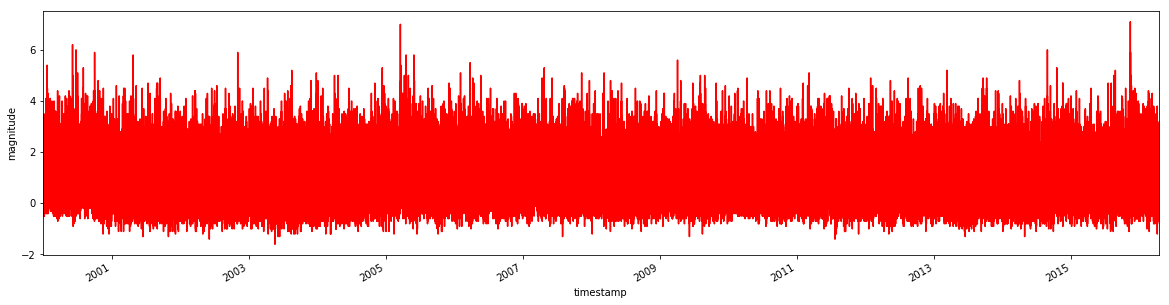

In [9]:
ax = df.mag.plot(figsize=(20,5), color='red')
ax.set_ylabel('magnitude')

In [10]:
df.describe()

,depth,idx,lat,lon,mag
count,309310.000000,3.093100e+05,309310.000000,309310.000000,309310.000000
mean,13.832391,1.294602e+06,32.370202,130.888181,0.799312
std,9.343145,6.858614e+05,1.047748,0.935363,0.758428
min,0.000000,1.000000e+00,29.000000,127.016833,-1.600000
25%,8.150000,7.867910e+05,31.969500,130.310833,0.300000
50%,10.610000,1.234172e+06,32.551167,130.760667,0.700000
75%,15.000000,1.773202e+06,33.086000,131.363833,1.200000
max,40.000000,2.545211e+06,34.000000,134.000000,7.100000


In [11]:
df[df.mag==df.mag.max()]

,depth,idx,lat,lon,mag,timestamp
timestamp,,,,,,
2015-11-13 20:51:30.109994,17.0,135577.0,30.943167,128.59,7.1,2015-11-13 20:51:30.109994


In [12]:
# lon_i = np.linspace(126.00, 135.00, 901).round(3)
# lat_i = np.linspace(28.00, 35.00, 701).round(3)

# bdata_to_map = pd.read_csv('b_15km_radius_map_FORESHOCKS_CUT.csv')
# bdata_to_map = bdata_to_map[bdata_to_map.n >= 50]
# new_index = [x for x in product(lon_i, lat_i)]
# bdata = bdata_to_map.set_index(['lon', 'lat']).reindex(new_index).reset_index().copy()
# lons = bdata.lon.values
# lats = bdata.lat.values

In [13]:
# bdata[(bdata.lat.between(32.95, 33.0)) & (bdata.lon.between(130.8, 131.0))].head(10)

# CHECK YO DATA

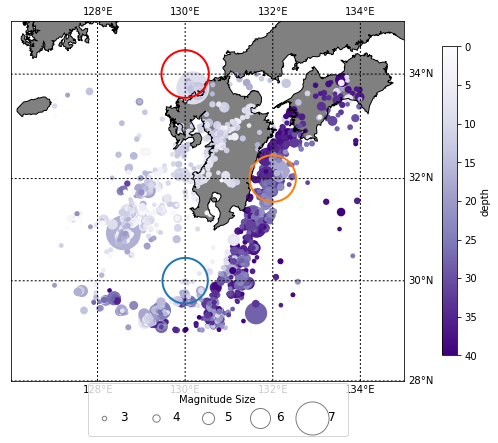

In [14]:
fig, ax = plt.subplots(1, figsize=(8,8))

# m = Basemap(projection='merc'
#            ,llcrnrlat=28.5
#            ,urcrnrlat=34.5
#            ,llcrnrlon=126.5
#            ,urcrnrlon=134.5
#            ,resolution='i'
#            ,area_thresh=1000
#            ,ax=ax)

m = Basemap(projection='merc'
           ,llcrnrlat=df.lat.min()-1
           ,urcrnrlat=df.lat.max()+1
           ,llcrnrlon=df.lon.min()-1
           ,urcrnrlon=df.lon.max()+1
           ,resolution='i'
           ,area_thresh=1000
           ,ax=ax)

labels = np.arange(0,180,2)
m.drawparallels(labels, labels=labels)
m.drawmeridians(labels, labels=labels)

m.drawcoastlines()
m.fillcontinents(color='gray', zorder=0)

# data = df[(df.mag > 2.5) & df.lat.between(32,34) & df.lon.between(130,132)]
d = df[(df.mag > 3)]


x, y = m(d.lon.values, d.lat.values)

cbar = ax.scatter(x, y, c=d.depth.values, s=np.exp(d.mag.values), edgecolor='None', vmin=0, vmax=40, cmap='Purples')
c1 = fig.colorbar(cbar, label='depth',fraction=0.0346, pad=0.084)
c1.ax.invert_yaxis()

sizes = np.exp([3,4,5,6,7])
label_plot = [ax.scatter([],[], s=s, edgecolors='black', color='white', alpha=0.5) for s in sizes]
labels = [x for x in range(3,11)]
ax.legend(label_plot, labels, ncol=10, frameon=True, fontsize=12, handlelength=0.75, loc='upper left'
        , borderpad = 1.,handletextpad=0.95, title='Magnitude Size', scatterpoints = 1
        , bbox_to_anchor=(0.18,0.0115))

equi(m, 130, 30, 50, lw=2)
equi(m, 132, 32, 50, lw=2)
equi(m, 130, 34, 50, lw=2, color='red')

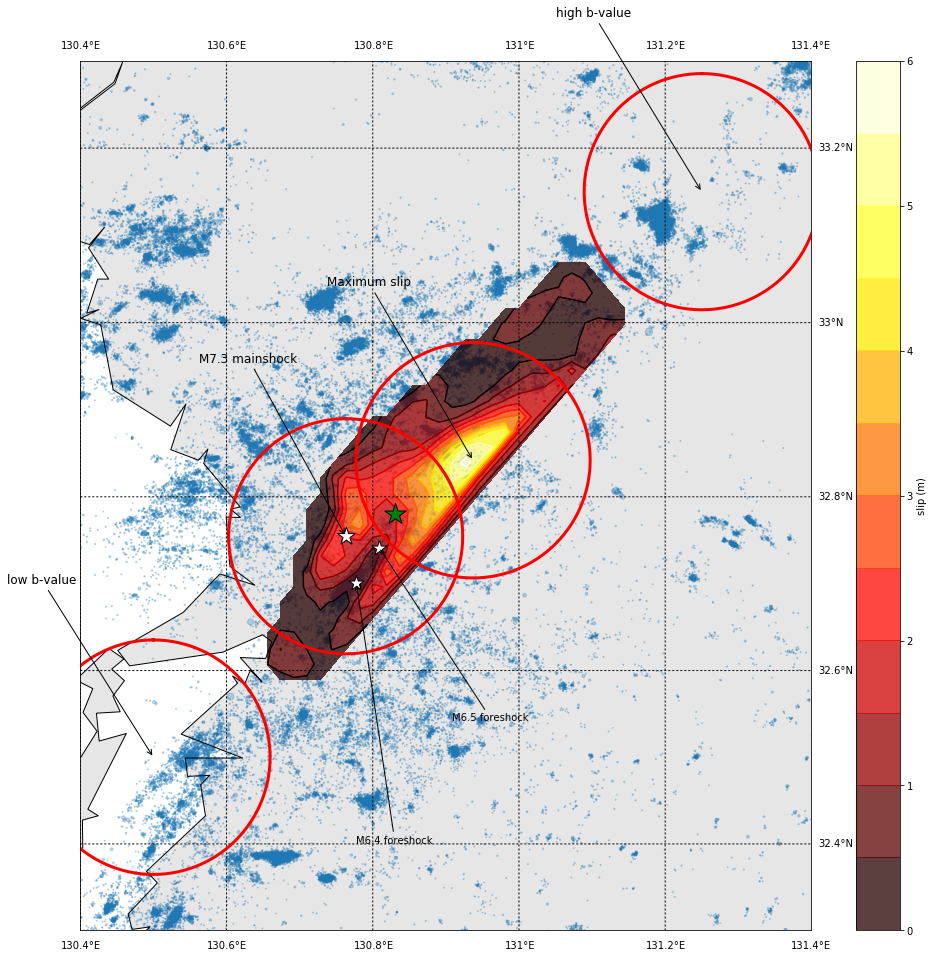

In [15]:
fig, ax = plt.subplots(1, figsize=(16,16))

m = Basemap(projection='merc'
           ,llcrnrlat=32.3
           ,urcrnrlat=33.3
           ,llcrnrlon=130.4
           ,urcrnrlon=131.4
           ,resolution='i'
           ,area_thresh=10
           ,ax=ax)

labels = np.arange(0,180,0.2)
m.drawparallels(labels, labels=labels)
m.drawmeridians(labels, labels=labels)

m.drawcoastlines()
m.fillcontinents(color='0.9', zorder=0)

x, y = m(df.lon.values, df.lat.values)
cbar = ax.scatter(x, y, s=np.exp(df.mag.values), alpha=0.275)

#max slip
max_slip = (130.9372, 32.84189)
equi(m, max_slip[0], max_slip[1], 15, lw=3, color='red')
x, y = m(max_slip[0], max_slip[1])
x2, y2 = m(max_slip[0]-0.2, max_slip[1] + 0.2)
# ax.scatter(x, y, marker='*', s=500, zorder=10, color='white', edgecolor='black')
ax.annotate('Maximum slip', fontsize=12, xy=(x,y), xycoords='data',
                xytext=(x2, y2), textcoords='data',
                arrowprops=dict(arrowstyle="->"), zorder=15)

#hypocenter
equi(m, fm_main[0], fm_main[1], 15, lw=3, color='red')
x, y = m(fm_main[0], fm_main[1])
ax.scatter(x, y, marker='*', s=350, color='white', edgecolor='black', zorder=20)
main_shock = (130.763, 32.7545)
x, y = m(main_shock[0], main_shock[1])
x2, y2 = m(main_shock[0]-0.2, main_shock[1] + 0.2)
# ax.scatter(x, y, marker='*', s=500, zorder=10, color='white', edgecolor='black')
ax.annotate('M7.3 mainshock', fontsize=12, xy=(x,y), xycoords='data',
                xytext=(x2, y2), textcoords='data',
                arrowprops=dict(arrowstyle="->"), zorder=15)

#high b-value
high_b = (131.25, 33.15,)
equi(m, high_b[0], high_b[1], 15, lw=3, color='red')
x, y = m(high_b[0], high_b[1])
x2, y2 = m(high_b[0]-0.2, high_b[1] + 0.2)
# ax.scatter(x, y, marker='*', s=500, zorder=10, color='white', edgecolor='black')
ax.annotate('high b-value', fontsize=12, xy=(x,y), xycoords='data',
                xytext=(x2, y2), textcoords='data',
                arrowprops=dict(arrowstyle="->"), zorder=15)

#low b-value
low_b = (130.5, 32.5)
equi(m, 130.5, 32.5, 15, lw=3, color='red')
x, y = m(low_b[0], low_b[1])
x2, y2 = m(low_b[0]-0.2, low_b[1] + 0.2)
# ax.scatter(x, y, marker='*', s=500, zorder=10, color='white', edgecolor='black')
ax.annotate('low b-value', fontsize=12, xy=(x,y), xycoords='data',
                xytext=(x2, y2), textcoords='data',
                arrowprops=dict(arrowstyle="->"), zorder=15)


slip_df['projected_lon'], slip_df['projected_lat'] = m(*(slip_df.lon.values, slip_df.lat.values))
xi = np.linspace(slip_df.projected_lon.min(), slip_df.projected_lon.max(), numcols)
yi = np.linspace(slip_df.projected_lat.min(), slip_df.projected_lat.max(), numrows)
xi, yi = np.meshgrid(xi, yi)
x, y, z = slip_df.projected_lon.values, slip_df.projected_lat.values, slip_df.slip.values
zi = griddata(x, y, z, xi, yi, interp='linear')
im = ax.contourf(xi, yi, zi, levels, cmap='hot', alpha=0.75)
im2 = ax.contour(xi, yi, zi, levels, cmap='hot', )
fig.colorbar(im, label='slip (m)', fraction=0.09)

nanjo_C = (130.83, 32.78)
x, y = m(nanjo_C[0], nanjo_C[1])
ax.scatter(x, y, marker='*', s=500, color='green', edgecolors='black', zorder=20)

foreshock65 = (130.808667, 32.741667)
x, y = m(foreshock65[0], foreshock65[1])
x2, y2 = m(foreshock65[0]+0.1, foreshock65[1] - 0.2)
ax.scatter(x, y, marker='*', s=250, zorder=10, color='white', edgecolor='black')
ax.annotate('M6.5 foreshock', xy=(x,y), xycoords='data',
                xytext=(x2, y2), textcoords='data',
                arrowprops=dict(arrowstyle="->"), zorder=15)

foreshock64 = (130.777667, 32.700667)
x, y = m(foreshock64[0], foreshock64[1])
x2, y2 = m(foreshock64[0]+0.0, foreshock64[1] - 0.3)
ax.scatter(x, y, marker='*', s=250, zorder=10, color='white', edgecolor='black')
ax.annotate('M6.4 foreshock', xy=(x,y), xycoords='data',
                xytext=(x2, y2), textcoords='data',
                arrowprops=dict(arrowstyle="->"), zorder=15)



# equi(m, 130.9372, 2.84189, 15, lw=2, zorder=20)

# ax.plot(59733.886466, 71502.420969, marker='*', markersize=15)

In [16]:
def gr_plot(gr_data, *args, **kwargs):
    fig, ax = plt.subplots(1, figsize=(6, 5))
    hist, edges = np.histogram(a=gr_data, bins=100, range=(0,10))
    chist = np.cumsum(hist[::-1])
#     ax.scatter(edges[:-1], hist, marker='s', facecolor='None', label='discrete')
#     ax.scatter(edges[::-1][:-1], chist, marker='^', facecolor='red', s=25, label='cumulative')
    ax.scatter(edges[::-1][:-1], chist, marker='^', s=25, label='cumulative')
    ax.set_yscale('log')
    ax.set_ylabel('N', rotation=0, fontsize=12)
    ax.set_xlabel('Magnitude')
    ax.legend()
    ax.grid(True)
    ax.set_ylim(1e0, chist[-1])
    ax.set_xlim(0, 10)
    # ax.set_title('Frequency Magnitude Distribution')

    a, b, bstd, n, mc = calc_fmd_stats_with_mc(gr_data)

    x = np.arange(0,10, 0.1)
    y = 10**(a - b * x)

    ax.plot(x, y)
    ax.text(s = 'Mc = {mc}\nb = {b}\nn = {n}'.format(mc=mc, b=round(b,3), n=n), x=7, y=chist.max()/10., fontsize=12)
    return fig, ax

In [17]:
def get_cumdist(data):
    hist, edges = np.histogram(a=data, bins=100, range=(0,10))
    chist = np.cumsum(hist[::-1])
    return edges, hist, chist

def plot_data_with_fit_line(ax, raw_data, chist, radius, **kwargs):
    a, b, bstd, n, mc = calc_fmd_stats_with_mc(raw_data.mag)
    label = radius + ', b={b}, mc={mc}, n={n}'.format(b=round(b,4),mc=mc,n=n)
    ax.scatter(chist[0][::-1][:-1], chist[2], label=label, **kwargs)
#     a, b, bstd, n, mc = calc_fmd_stats_with_mc(raw_data.mag)
    x = np.arange(0, 10, 0.1)
    y = 10**(a - b * x)
    ax.plot(x, y, color='black')

# Min magnitude

In [18]:
df_min = df[df.mag > 0.5].copy()

# Nanjo C

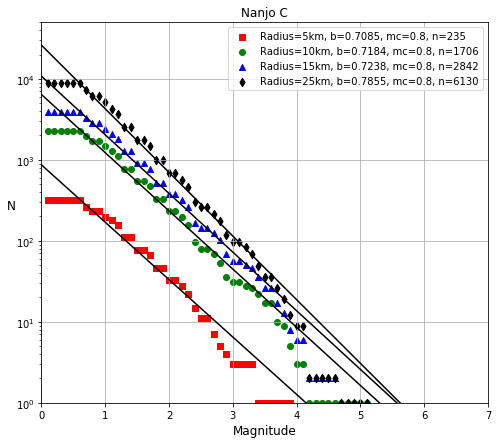

In [19]:

low_b_data_5 = get_node_data(node=nanjo_C, radius=5, data=df_min)
low_b_data_10 = get_node_data(node=nanjo_C, radius=10, data=df_min)
low_b_data_15 = get_node_data(node=nanjo_C, radius=15, data=df_min)
low_b_data_25 = get_node_data(node=nanjo_C, radius=25, data=df_min)

chist5 = get_cumdist(low_b_data_5.mag)
chist10 = get_cumdist(low_b_data_10.mag)
chist15 = get_cumdist(low_b_data_15.mag)
chist25 = get_cumdist(low_b_data_25.mag)

fig, ax = plt.subplots(figsize=(8,7))

plot_data_with_fit_line(ax=ax, raw_data=low_b_data_5, chist=chist5, radius='Radius=5km', color='red', marker='s')
plot_data_with_fit_line(ax=ax, raw_data=low_b_data_10, chist=chist10, radius='Radius=10km', color='green', marker='o')
plot_data_with_fit_line(ax=ax, raw_data=low_b_data_15, chist=chist15, radius='Radius=15km', color='blue', marker='^')
plot_data_with_fit_line(ax=ax, raw_data=low_b_data_25, chist=chist25, radius='Radius=25km', color='black', marker='d')

# ax.scatter(chist5[0][::-1][:-1], chist5[2], marker='^', s=25, label='Radius=5km'
#           , color='red')
# a, b, bstd, n, mc = calc_fmd_stats_with_mc(low_b_data_5.mag)

# x = np.arange(0,10, 0.1)
# y = 10**(a - b * x)

# ax.plot(x, y)

ax.set_yscale('log')
ax.set_ylabel('N', rotation=0, fontsize=12)
ax.set_xlabel('Magnitude', fontsize=12)
ax.grid(True)
ax.set_ylim(1e0, 5e4)
ax.set_xlim(0,7)
ax.legend()
ax.set_title('Nanjo C')

# Low b-value

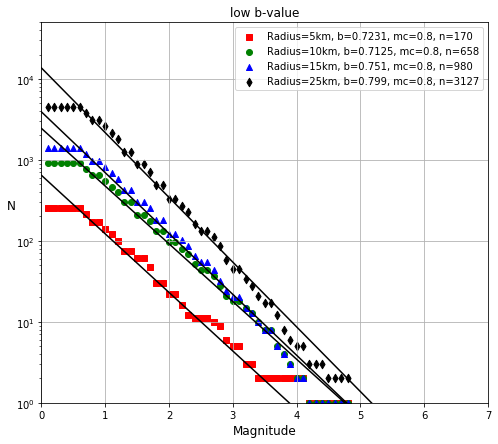

In [20]:
low_b_data_5 = get_node_data(node=low_b, radius=5, data=df_min)
low_b_data_10 = get_node_data(node=low_b, radius=10, data=df_min)
low_b_data_15 = get_node_data(node=low_b, radius=15, data=df_min)
low_b_data_25 = get_node_data(node=low_b, radius=25, data=df_min)

chist5 = get_cumdist(low_b_data_5.mag)
chist10 = get_cumdist(low_b_data_10.mag)
chist15 = get_cumdist(low_b_data_15.mag)
chist25 = get_cumdist(low_b_data_25.mag)

fig, ax = plt.subplots(figsize=(8,7))

plot_data_with_fit_line(ax=ax, raw_data=low_b_data_5, chist=chist5, radius='Radius=5km', color='red', marker='s')
plot_data_with_fit_line(ax=ax, raw_data=low_b_data_10, chist=chist10, radius='Radius=10km', color='green', marker='o')
plot_data_with_fit_line(ax=ax, raw_data=low_b_data_15, chist=chist15, radius='Radius=15km', color='blue', marker='^')
plot_data_with_fit_line(ax=ax, raw_data=low_b_data_25, chist=chist25, radius='Radius=25km', color='black', marker='d')

# ax.scatter(chist5[0][::-1][:-1], chist5[2], marker='^', s=25, label='Radius=5km'
#           , color='red')
# a, b, bstd, n, mc = calc_fmd_stats_with_mc(low_b_data_5.mag)

# x = np.arange(0,10, 0.1)
# y = 10**(a - b * x)

# ax.plot(x, y)

ax.set_yscale('log')
ax.set_ylabel('N', rotation=0, fontsize=12)
ax.set_xlabel('Magnitude', fontsize=12)
ax.grid(True)
ax.set_ylim(1e0, 5e4)
ax.set_xlim(0,7)
ax.legend()
ax.set_title('low b-value')

# Hypocenter

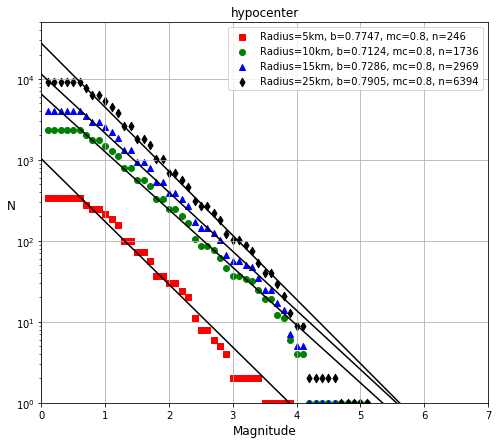

In [21]:
low_b_data_5 = get_node_data(node=fm_main[0:2], radius=5, data=df_min)
low_b_data_10 = get_node_data(node=fm_main[0:2], radius=10, data=df_min)
low_b_data_15 = get_node_data(node=fm_main[0:2], radius=15, data=df_min)
low_b_data_25 = get_node_data(node=fm_main[0:2], radius=25, data=df_min)

chist5 = get_cumdist(low_b_data_5.mag)
chist10 = get_cumdist(low_b_data_10.mag)
chist15 = get_cumdist(low_b_data_15.mag)
chist25 = get_cumdist(low_b_data_25.mag)

fig, ax = plt.subplots(figsize=(8,7))

plot_data_with_fit_line(ax=ax, raw_data=low_b_data_5, chist=chist5, radius='Radius=5km', color='red', marker='s')
plot_data_with_fit_line(ax=ax, raw_data=low_b_data_10, chist=chist10, radius='Radius=10km', color='green', marker='o')
plot_data_with_fit_line(ax=ax, raw_data=low_b_data_15, chist=chist15, radius='Radius=15km', color='blue', marker='^')
plot_data_with_fit_line(ax=ax, raw_data=low_b_data_25, chist=chist25, radius='Radius=25km', color='black', marker='d')

# ax.scatter(chist5[0][::-1][:-1], chist5[2], marker='^', s=25, label='Radius=5km'
#           , color='red')
# a, b, bstd, n, mc = calc_fmd_stats_with_mc(low_b_data_5.mag)

# x = np.arange(0,10, 0.1)
# y = 10**(a - b * x)

# ax.plot(x, y)

ax.set_yscale('log')
ax.set_ylabel('N', rotation=0, fontsize=12)
ax.set_xlabel('Magnitude', fontsize=12)
ax.grid(True)
ax.set_ylim(1e0, 5e4)
ax.set_xlim(0,7)
ax.legend()
ax.set_title('hypocenter')

# Maximum slip

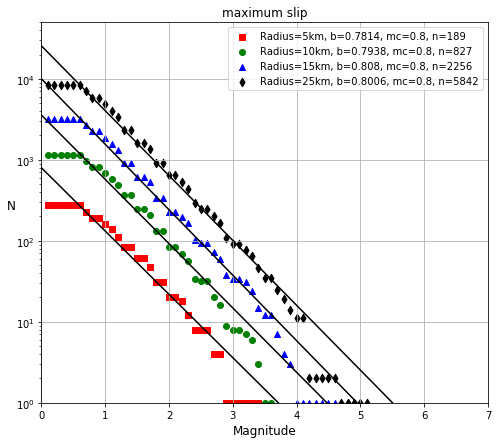

In [22]:
low_b_data_5 = get_node_data(node=max_slip, radius=5, data=df_min)
low_b_data_10 = get_node_data(node=max_slip, radius=10, data=df_min)
low_b_data_15 = get_node_data(node=max_slip, radius=15, data=df_min)
low_b_data_25 = get_node_data(node=max_slip, radius=25, data=df_min)

chist5 = get_cumdist(low_b_data_5.mag)
chist10 = get_cumdist(low_b_data_10.mag)
chist15 = get_cumdist(low_b_data_15.mag)
chist25 = get_cumdist(low_b_data_25.mag)

fig, ax = plt.subplots(figsize=(8,7))

plot_data_with_fit_line(ax=ax, raw_data=low_b_data_5, chist=chist5, radius='Radius=5km', color='red', marker='s')
plot_data_with_fit_line(ax=ax, raw_data=low_b_data_10, chist=chist10, radius='Radius=10km', color='green', marker='o')
plot_data_with_fit_line(ax=ax, raw_data=low_b_data_15, chist=chist15, radius='Radius=15km', color='blue', marker='^')
plot_data_with_fit_line(ax=ax, raw_data=low_b_data_25, chist=chist25, radius='Radius=25km', color='black', marker='d')

# ax.scatter(chist5[0][::-1][:-1], chist5[2], marker='^', s=25, label='Radius=5km'
#           , color='red')
# a, b, bstd, n, mc = calc_fmd_stats_with_mc(low_b_data_5.mag)

# x = np.arange(0,10, 0.1)
# y = 10**(a - b * x)

# ax.plot(x, y)

ax.set_yscale('log')
ax.set_ylabel('N', rotation=0, fontsize=12)
ax.set_xlabel('Magnitude', fontsize=12)
ax.grid(True)
ax.set_ylim(1e0, 5e4)
ax.set_xlim(0,7)
ax.legend()
ax.set_title('maximum slip')

# high b-value

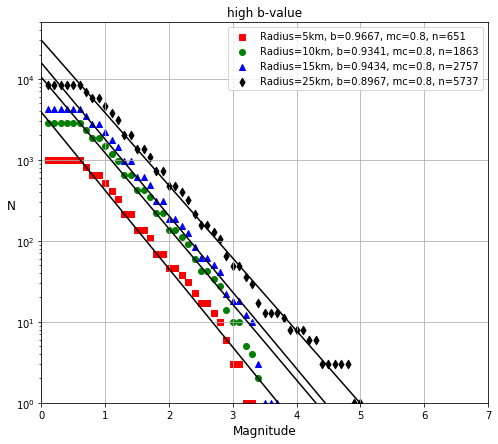

In [23]:
low_b_data_5 = get_node_data(node=high_b, radius=5, data=df_min)
low_b_data_10 = get_node_data(node=high_b, radius=10, data=df_min)
low_b_data_15 = get_node_data(node=high_b, radius=15, data=df_min)
low_b_data_25 = get_node_data(node=high_b, radius=25, data=df_min)

chist5 = get_cumdist(low_b_data_5.mag)
chist10 = get_cumdist(low_b_data_10.mag)
chist15 = get_cumdist(low_b_data_15.mag)
chist25 = get_cumdist(low_b_data_25.mag)

fig, ax = plt.subplots(figsize=(8,7))

plot_data_with_fit_line(ax=ax, raw_data=low_b_data_5, chist=chist5, radius='Radius=5km', color='red', marker='s')
plot_data_with_fit_line(ax=ax, raw_data=low_b_data_10, chist=chist10, radius='Radius=10km', color='green', marker='o')
plot_data_with_fit_line(ax=ax, raw_data=low_b_data_15, chist=chist15, radius='Radius=15km', color='blue', marker='^')
plot_data_with_fit_line(ax=ax, raw_data=low_b_data_25, chist=chist25, radius='Radius=25km', color='black', marker='d')

# ax.scatter(chist5[0][::-1][:-1], chist5[2], marker='^', s=25, label='Radius=5km'
#           , color='red')
# a, b, bstd, n, mc = calc_fmd_stats_with_mc(low_b_data_5.mag)

# x = np.arange(0,10, 0.1)
# y = 10**(a - b * x)

# ax.plot(x, y)

ax.set_yscale('log')
ax.set_ylabel('N', rotation=0, fontsize=12)
ax.set_xlabel('Magnitude', fontsize=12)
ax.grid(True)
ax.set_ylim(1e0, 5e4)
ax.set_xlim(0,7)
ax.legend()
ax.set_title('high b-value')

In [24]:
fm_main

(130.763, 32.7545, 128, 74, -14)

In [25]:
m(59733.886466, 71502.420969, inverse=True)

(130.93720000000243, 32.84189999997246)

/home/max/anaconda2/envs/research/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3274: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/max/anaconda2/envs/research/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3283: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


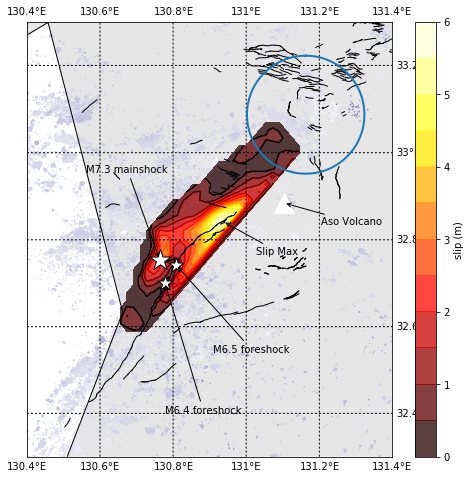

In [26]:
fig, ax = plt.subplots(1, figsize=(8,8))

m = Basemap(projection='merc'
           ,llcrnrlat=32.3
           ,urcrnrlat=33.3
           ,llcrnrlon=130.4
           ,urcrnrlon=131.4
           ,resolution='c'
           ,area_thresh=10
           ,ax=ax)

labels = np.arange(0,180,0.2)
m.drawparallels(labels, labels=labels)
m.drawmeridians(labels, labels=labels)

m.drawcoastlines()
m.fillcontinents(color='0.9', zorder=0)

# data = df[(df.mag > 2.5) & df.lat.between(32,34) & df.lon.between(130,132)]
d = df[df.mag>0]


x, y = m(d.lon.values, d.lat.values)

cbar = ax.scatter(x, y, c=d.depth.values, s=np.exp(d.mag.values), edgecolor='None', vmin=0, vmax=40, cmap='Purples')
# c1 = fig.colorbar(cbar, label='depth')
# c1.ax.invert_yaxis()




slip_df['projected_lon'], slip_df['projected_lat'] = m(*(slip_df.lon.values, slip_df.lat.values))
xi = np.linspace(slip_df.projected_lon.min(), slip_df.projected_lon.max(), numcols)
yi = np.linspace(slip_df.projected_lat.min(), slip_df.projected_lat.max(), numrows)
xi, yi = np.meshgrid(xi, yi)
x, y, z = slip_df.projected_lon.values, slip_df.projected_lat.values, slip_df.slip.values
zi = griddata(x, y, z, xi, yi, interp='linear')
im = ax.contourf(xi, yi, zi, levels, cmap='hot', alpha=0.75)
im2 = ax.contour(xi, yi, zi, levels, cmap='hot', )

fig.colorbar(im, label='slip (m)', fraction=0.09)


m.plot(aso_volcano[0], aso_volcano[1], marker='^', markersize=20, zorder=25, latlon=True, color='white')
x, y = m(aso_volcano[0], aso_volcano[1])
x2, y2 = m(aso_volcano[0] + 0.1, aso_volcano[1] - 0.05)
ax.annotate('Aso Volcano', xy=(x,y), xycoords='data',
                xytext=(x2, y2), textcoords='data',
                arrowprops=dict(arrowstyle="->"), zorder=25)
# x2, y2 = map(0, 0)
# plt.annotate('Barcelona', xy=(x, y),  xycoords='data',
#                 xytext=(x2, y2), textcoords='data',
#                 arrowprops=dict(arrowstyle="->")
#                 )

main_shock = (130.763, 32.7545)
x, y = m(main_shock[0], main_shock[1])
x2, y2 = m(main_shock[0]-0.2, main_shock[1] + 0.2)
ax.scatter(x, y, marker='*', s=500, zorder=10, color='white', edgecolor='black')
ax.annotate('M7.3 mainshock', xy=(x,y), xycoords='data',
                xytext=(x2, y2), textcoords='data',
                arrowprops=dict(arrowstyle="->"), zorder=15)


for fault in fault_coordinates:
    x, y = m(fault[:,0], fault[:,1])
    ax.plot(x, y, color='black', linewidth=1)

foreshock65 = (130.808667, 32.741667)
x, y = m(foreshock65[0], foreshock65[1])
x2, y2 = m(foreshock65[0]+0.1, foreshock65[1] - 0.2)
ax.scatter(x, y, marker='*', s=250, zorder=10, color='white', edgecolor='black')
ax.annotate('M6.5 foreshock', xy=(x,y), xycoords='data',
                xytext=(x2, y2), textcoords='data',
                arrowprops=dict(arrowstyle="->"), zorder=15)

foreshock64 = (130.777667, 32.700667)
x, y = m(foreshock64[0], foreshock64[1])
x2, y2 = m(foreshock64[0]+0.0, foreshock64[1] - 0.3)
ax.scatter(x, y, marker='*', s=250, zorder=10, color='white', edgecolor='black')
ax.annotate('M6.4 foreshock', xy=(x,y), xycoords='data',
                xytext=(x2, y2), textcoords='data',
                arrowprops=dict(arrowstyle="->"), zorder=15)

# slipmax = (131.162700, 33.087100)
slipmax = (59733.886466, 71502.420969)
# x, y = m(slipmax[0], slipmax[1])
x, y = slipmax
# x2, y2 = m(slipmax[0]+0.0, slipmax[1] - 0.3)
x2, y2 = slipmax
# ax.scatter(x, y, marker='*', s=250, zorder=10, color='white', edgecolor='black')
ax.annotate('Slip Max', xy=(x,y), xycoords='data',
                xytext=(x2+10000, y2-10000), textcoords='data',
                arrowprops=dict(arrowstyle="->"), zorder=15)

# equi(m, 59733.886466, 71502.420969, radius, lw=2)

centerlon, centerlat = (131.162700, 33.087100)
radius = 15
equi(m, centerlon, centerlat, radius, lw=2.)